# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [15]:
! pip install SimpleITK==1.2.2 
# ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
# ! unzip brainage-data.zip

# # data directory
data_dir = '../data/brain_age/'

### Running on DoC lab machines

In [16]:
# data directory
# data_dir = '/vol/lab/course/416/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [17]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


In [18]:
meta_data_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
meta_data_test.head()

,Unnamed: 0,subject_id,age,gender_code,gender_text
0,262,CC321594,43,1,MALE
1,41,CC120640,26,2,FEMALE
2,647,CC722542,79,1,MALE
3,479,CC610227,76,2,FEMALE
4,185,CC310463,45,2,FEMALE


Let's have a look at some population statistics.

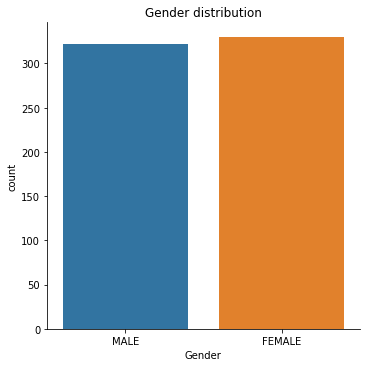

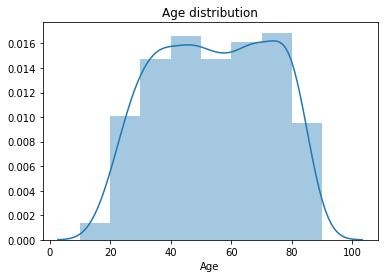

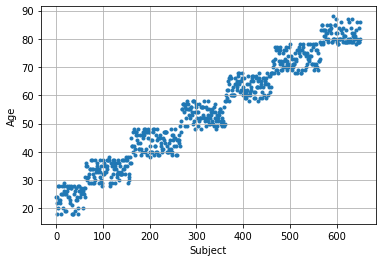

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [20]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

(98, 116, 94)
(98, 116, 94)
(90, 108, 90)
Imaging data of subject CC110033 with age 24

MR Image (used in part A)


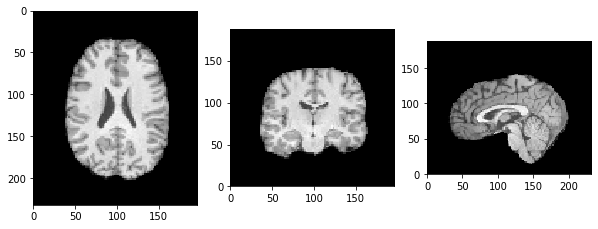

Brain mask (used in part A)


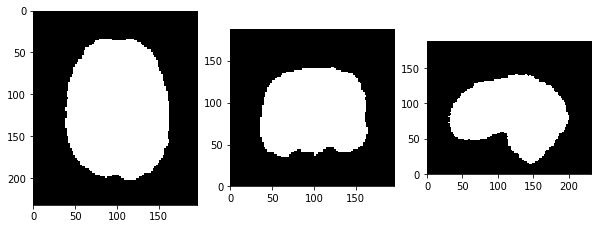

Spatially normalised grey matter maps (used in part B and C)


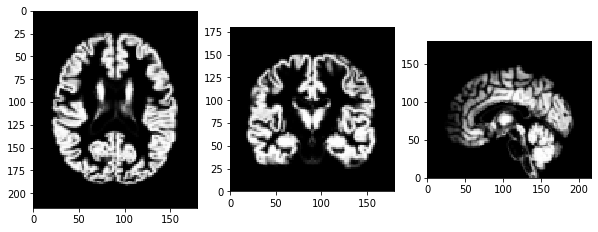

In [21]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)
print(img.GetSize())
# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)
print(msk.GetSize())
# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)
print(gm.GetSize())
print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [22]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [23]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [24]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla K80


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [25]:
rnd_seed = 42 #fixed random seed

img_size = [76, 98, 88]
img_spacing = [2, 2, 2]

num_epochs = 100
num_save_epochs = 20

learning_rate = 5e-4
batch_size = 2
val_interval = 10 # Validation Interval

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    

#### Loading and pre-processing of training and validation data

In [26]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

In [27]:
meta_data_seg_test = meta_data_test
ids_seg_test = list(meta_data_seg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [28]:
# LOAD ACTUAL TRAINING DATA
#dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


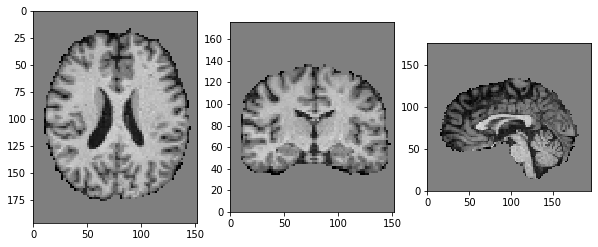

Segmentation


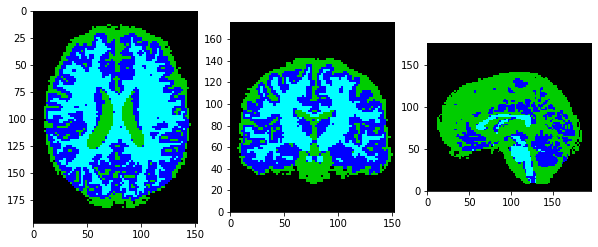

Mask


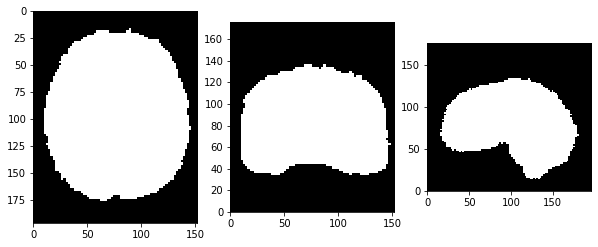

In [29]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [39]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class ModelBlock(nn.Module): 
    def __init__(self, block):
        super(ModelBlock, self).__init__() 
        self.block = nn.Sequential(*block)
    
    def forward(self, x): 
        out = self.block(x) 
        return out

class ResBlock(nn.Module): 
    def __init__(self, in_channel, out_channel, kernel_size = 3, stride=1, dp = 0.05): 
        
        super(ResBlock, self).__init__() 
        
        self.left = nn.Sequential(nn.Conv3d(in_channel, out_channel, 
                                            kernel_size=kernel_size, stride=stride, 
                                            padding=1, bias=False), 
                                  nn.BatchNorm3d(out_channel), 
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(p=dp), 
                                  
                                  nn.Conv3d(out_channel, out_channel, 
                                            kernel_size=kernel_size, stride=1, 
                                            padding=1, bias=False), 
                                  nn.BatchNorm3d(out_channel), 
                                  nn.Dropout(p=dp))
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or in_channel != out_channel: 
            
            self.shortcut = nn.Sequential(nn.Conv3d(in_channel, out_channel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm3d(out_channel),
                                          nn.Dropout(p=dp)) 

            
    def forward(self, x): 
#         print('HERE')
#         print(x.shape)
        out = self.left(x)
        out += self.shortcut(x) 
        out = F.relu(out) 
#         print(out.shape)
        return out


class ResidualNet3D(nn.Module):

    def __init__(self, ResBlock, ModelBlock, num_classes):
        super(ResidualNet3D, self).__init__()
        
        f = 1
        self.in_channel = int(12*f)
#         self.fc_in_features =  864   
#         self.fc_in_features =  256  
        self.fc_in_features = None
        self.conv1 = nn.Sequential(nn.Conv3d(1, self.in_channel, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm3d(self.in_channel),
                                  nn.ReLU(inplace = True),
                                  nn.Dropout(p=0.05))
                                  
        self.layer1 = self.make_layer(ResBlock, num_blocks = 2, out_channel = int(18*f), stride = 1)
        self.layer2 = self.make_layer(ResBlock, num_blocks = 2, out_channel = int(24*f), stride = 1)
        self.layer3 = self.make_layer(ResBlock, num_blocks = 2, out_channel = int(32*f), stride = 1)
        self.layer4 = self.make_layer(ResBlock, num_blocks = 2, out_channel = int(40*f), stride = 1)
        self.OutLayer = nn.Conv3d(int(40*f), num_classes, kernel_size=3, padding=1, stride = 1)
        
        # USED FOR CLASSIFICATION TASK, ALSO INCREASE STRIDING OF BLOCKS TO 2!
        #self.maxpool = nn.MaxPool3d(2)
        #self.fc = self.make_fc([80,40],num_classes)
                                  
    def make_layer(self, block, num_blocks, out_channel, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(ResBlock(self.in_channel, out_channel, stride = stride))
            self.in_channel = out_channel 
            
        return nn.Sequential(*layers)
    
    # USED FOR CLASSIFICATION TASK
    def make_fc(self, hidden_layers, num_classes):
        
        layers = []
        fc_layers = hidden_layers + [num_classes]
        in_features = self.fc_in_features
        
        for hl in fc_layers:
            if hl is fc_layers[-1]:
                block = [nn.Linear(in_features,hl, bias = True), nn.Softmax(dim = 1)]
            else:
                block = [nn.Linear(in_features,hl, bias = True), nn.ReLU(inplace = True)]
            module_block = ModelBlock(block)
            layers.append(module_block)
            in_features = hl
            
        return nn.Sequential(*layers)
                                  
    def forward(self, x):
        x = F.relu(self.conv1(x),inplace=True)
        x = F.relu(self.layer1(x),inplace=True)
        x = F.relu(self.layer2(x),inplace=True)
        x = F.relu(self.layer3(x),inplace=True)
        x = F.relu(self.layer4(x),inplace=True)
        x = self.OutLayer(x)
        x = F.softmax(x, dim=1)
        return x     

torch.manual_seed(rnd_seed) #fix random seed
# torch.cuda.empty_cache()

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
model = ResidualNet3D(ResBlock, ModelBlock, num_classes=num_classes).to(device)

weights_initialiser = True

if weights_initialiser:
    model.apply(weights_init)
params_net = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in Model is: {}".format(params_net))
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.95)

Total number of parameters in Model is: 363501
ResidualNet3D(
  (conv1): Sequential(
    (0): Conv3d(1, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.05, inplace=False)
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv3d(12, 18, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.05, inplace=False)
        (4): Conv3d(18, 18, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (5): BatchNorm3d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Dropout(p=0.05, inplace=False)
      )
      (shortcut): Sequential(
        (0): Conv3d(12, 18, kernel_size=(1, 1,

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

In [ ]:
loss_train_log = []
loss_val_log = []
epoch_val_log = []

model.train()

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.detach().item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')
        
    if epoch % num_save_epochs == 0:
        print('SAVING MODEL JUST IN CASE')
        torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')
torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))
print('FULL MODEL SAVED SUCCESSFULLY')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [41]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


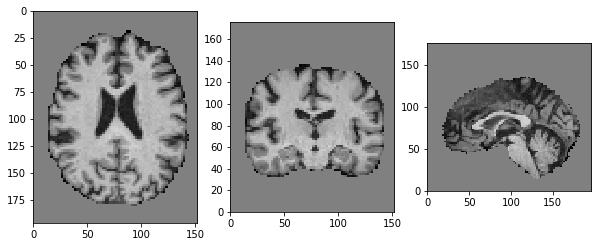

Segmentation


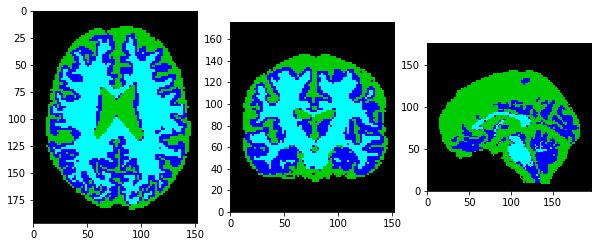

Mask


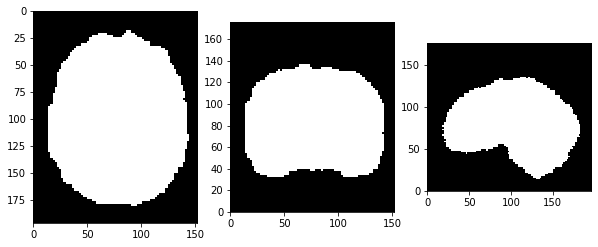

In [147]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.785366


Reference segmentation


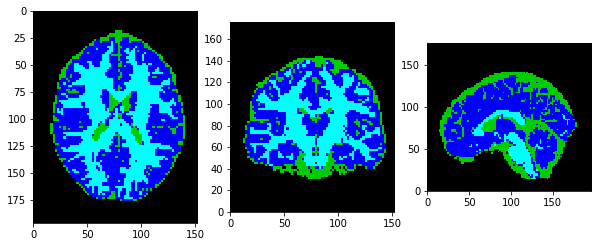

Predicted segmentation


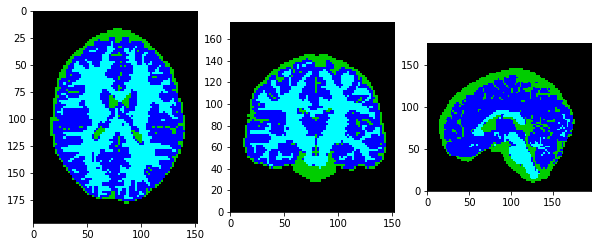


Finished TESTING.


[Text(0, 0.5, 'VS Score')]

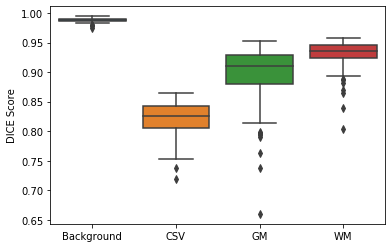

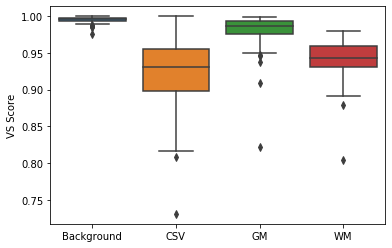

In [42]:
import seaborn as sns

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = ResidualNet3D(ResBlock, ModelBlock, num_classes=4)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()

def iterate_DICE(prd,seg,DICE):
    total_pixels = 88*98*76
    for idx in range(4):
        
        prd_idx = (prd == idx)
        prd_n_idx = (prd != idx)

        DICE['C{}'.format(idx)]['TP'].append(torch.sum(seg[prd_idx] == idx).item()/total_pixels)
        DICE['C{}'.format(idx)]['FP'].append(torch.sum(seg[prd_idx] != idx).item()/total_pixels)
        DICE['C{}'.format(idx)]['TN'].append(torch.sum(seg[prd_n_idx] != idx).item()/total_pixels)
        DICE['C{}'.format(idx)]['FN'].append(torch.sum(seg[prd_n_idx] == idx).item()/total_pixels)
    return DICE

DICE = {'C0':{'TP':[],'FP':[],'TN':[],'FN':[]}, 
         'C1':{'TP':[],'FP':[],'TN':[],'FN':[]}, 
         'C2':{'TP':[],'FP':[],'TN':[],'FN':[]}, 
         'C3':{'TP':[],'FP':[],'TN':[],'FN':[]}}

print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)
        
        iterate_DICE(prd[0],seg[0,0],DICE)
        
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

# calculate DICE and VOLUME SIMILARITY from TP, FN, FP, TN
for key in DICE.keys():
    p_stat = DICE[key]
    DICE[key]['DICE'] = 2*np.array(p_stat['TP'])/(2*np.array(p_stat['TP']) + np.array(p_stat['FP']) + np.array(p_stat['FN']))
    DICE[key]['VS'] = 1 - np.abs(np.array(p_stat['FN'])-np.array(p_stat['FP']))/(2*np.array(p_stat['TP'])+np.array(p_stat['FP'])+np.array(p_stat['FN']))

DDICE = {key:DICE[key]['DICE'] for key in DICE.keys()}
VSDICE = {key:DICE[key]['VS'] for key in DICE.keys()}

dd = pd.DataFrame(DDICE)
dd.rename(columns={"C0": "Background", "C1": "CSV", "C2": "GM", "C3":"WM"}, inplace = True)
vv = pd.DataFrame(VSDICE)
vv.rename(columns={"C0": "Background", "C1": "CSV", "C2": "GM", "C3":"WM"},inplace = True)

print('\nFinished TESTING.')

ax = sns.boxplot(data=dd)
ax.set(ylabel='DICE Score')
plt.figure()
ax = sns.boxplot(data=vv)
ax.set(ylabel='VS Score')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

#### Train and validation data

In [30]:
## CALCULATE ABSOLUTE TISSUE VOLUMES
import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = 'output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
# seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):

    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        ########################################
        # ADD YOUR CODE HERE
        
        # Compute the absolute volume of the image in mm^3
        size = seg.GetSize()
        spacing = seg.GetSpacing()

        width  = size[0] * spacing[0]
        height = size[1] * spacing[1]
        depth  = size[2] * spacing[2]
        
        image_volume = width*height*depth
        
        
        # Compute the number of pixels for each label
        labels = sitk.GetArrayFromImage(seg)
        
        bckg_pix = (labels==0).sum()
        csf_pix = (labels==1).sum()
        gm_pix = (labels==2).sum()
        wm_pix = (labels==3).sum()
        
        ## volumes in mm^3 in the volumes array directly
        vols[0,idx] = image_volume*(csf_pix/labels.size)
        vols[1,idx] = image_volume*(gm_pix/labels.size)
        vols[2,idx] = image_volume*(wm_pix/labels.size) 

        ########################################

Calculating Features: 100%|██████████| 500/500 [00:02<00:00, 172.08it/s]


#### Test data

In [31]:
## Getting the testing data volumes
meta_data_reg_test = pd.read_csv(data_dir + '/meta/meta_data_reg_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

vols_test = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):

    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        ########################################
        # ADD YOUR CODE HERE
        
        # Compute the absolute volume of the image in mm^3
        size = seg.GetSize()
        spacing = seg.GetSpacing()

        width  = size[0] * spacing[0]
        height = size[1] * spacing[1]
        depth  = size[2] * spacing[2]
        
        image_volume = width*height*depth
        
        
        # Compute the number of pixels for each label
        labels = sitk.GetArrayFromImage(seg)
        
        bckg_pix = (labels==0).sum()
        csf_pix = (labels==1).sum()
        gm_pix = (labels==2).sum()
        wm_pix = (labels==3).sum()
        
        ## volumes in mm^3 in the volumes array directly
#         bckg_phy_vol = image_volume*(bckg_pix/labels.size)
        vols_test[0,idx] = image_volume*(csf_pix/labels.size)
        vols_test[1,idx] = image_volume*(gm_pix/labels.size)
        vols_test[2,idx] = image_volume*(wm_pix/labels.size) 

        ########################################

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 173.34it/s]


Plot features versus age.

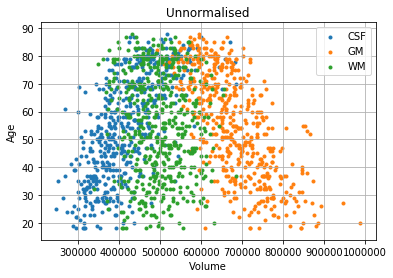

In [32]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [33]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))
vols_test_normalised = np.zeros((3,len(files_reg_seg_test)))

########################################
# ADD YOUR CODE HERE
vols_normalised = vols/vols.sum(axis=0)
vols_test_normalised = vols_test/vols_test.sum(axis=0)
########################################

Plot normalised features versus age.

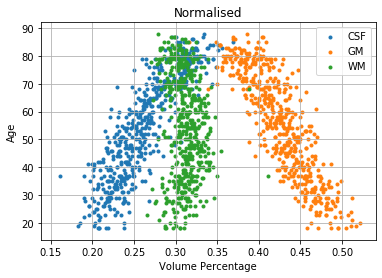

In [34]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume Percentage')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [35]:
X_trainval = vols_normalised.T
y_trainval = meta_data_reg_train['age'].values.reshape(-1,1)

X_test = vols_test_normalised.T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

In [36]:
# Extra features? Does anything seem to appear logical hehe maybe 1/tissue_volumes for the two GM and WM?
# The simplest i find is simply to use only CSF and GM as the WM does not seem to provide any information
def _reduce_features(X):
    X_reduced =  X[:,:2]
    return X_reduced 

### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [37]:
## Imports for the cross validation and model testing
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#### Resampling and augmenting the data

In [38]:
########################################
# ADD YOUR CODE HERE

## Getting the extra data/upsamlping
def _augment_data(features, labels, augmentation):
    '''This fucntion serves to augment the data according to the inverse of their
    probability distribution function in order to perfrom upsampling of the
    imbalanced age groups.
    Input: 
        features: np array of shape [number of samples, number of features]
        labels: np array of shape [number of samples, number of labels]
        augmentation: float, %in data aumentation required
    Return:
        X_total: np array of shape [number of samples *(1+augmentation), number of features]
        y_total: np array of shape [number of samples *(1+augmentation), number of labels]
        upsampled_points: number of points added to the dataset'''
    
    n, bins = np.histogram(y_trainval, 30, density=True)
    prob_dist = np.ones(len(n))-n*35
    prob_dist = np.clip(prob_dist, 0, 1)
    prob_dist = prob_dist/sum(prob_dist)
    prob_dist_scaled = prob_dist**2/sum(prob_dist**2)
    probs = np.ones(len(labels))

    # distriubute the probas according to the ages
    for idx in range(len(bins)-1):
        probs[(labels[:,0]>=bins[idx])&(labels[:,0]<=bins[idx+1])] = 1*prob_dist[idx]  
    scaled_probs = probs/sum(probs)
    scaled_probs = scaled_probs**2/sum(scaled_probs**2)

    upsampled_points = int(augmentation*features.shape[0])
    idxs = np.random.choice(len(labels), p=scaled_probs, size = upsampled_points)
    X_augmentation = np.zeros((len(idxs),features.shape[1]))
    y_augmentation = np.zeros((len(idxs),labels.shape[1]))
    
    # Adding noise propotrional to that of the resampling probability and standard deviation of the features
    features_std = features.std(axis=0)

    for i, value in enumerate(idxs):
        X_augmentation[i,:] = features[value,:] + np.random.normal(0, 
                                                                   features_std*5*scaled_probs[value], 
                                                                   features[value,:].shape)
        y_augmentation[i,:] = labels[value,:]

    X_augmentation = np.clip(X_augmentation, 0, 1)

    y_total=np.concatenate((labels, y_augmentation), axis=0)
    X_total=np.concatenate((features, X_augmentation), axis=0)
    
    return X_total, y_total, upsampled_points, prob_dist_scaled

#### Getting the indices/iterables for the cross validation

In [39]:
# indices for the cross validation iterator
def _get_cv(idx_xs1, idx_xs2, upsampled_points):
    '''This function serves to create the iterables for a 2 fold cross-validation.
    Input: 
        idx_xs1: np array of shape [number of samples in fold]
        idx_xs2: np array of shape [number of samples in fold]
        upsampled_points: int, number of additional points that have been obtained by upsampling
    Return:
        cv: tuple of tuples, iterable containing the indices of data to perform the 2 fold cross validation'''
    
    train1_max_idx = idx_xs1.shape[0] + upsampled_points
    test1_min_idx = train1_max_idx
    test1_max_idx = test1_min_idx + idx_xs2.shape[0]
    
    train2_min_idx = test1_min_idx
    train2_max_idx = test1_max_idx + upsampled_points
    test2_max_idx = idx_xs1.shape[0]

    cv = ((np.arange(0, train1_max_idx).tolist(), np.arange(test1_min_idx, test1_max_idx).tolist()),
          (np.arange(train2_min_idx, train2_max_idx).tolist(), np.arange(0, test2_max_idx).tolist()))
    
    return cv

#### Getting all the data for the cross validation

In [48]:
# Full pipeline

def get_data_for_cross_val(X, y, features='full', augment=False, augment_percent=0.4):
    '''This fucntion serves to obtain the data to perform 2 fold cross validation ie: the features,
    labels, and cv validation iterable. It randomly selects half of each of the dataset and performs 
    augmentation (if required) on the training sets only.
    Input:
        X: np array containing the full train/validation set features of shape [samples, features]
        y: np array containing the full train/validation set labels of shape [samples, labels]
        features: string to specify if all the features are used, or only the reduced set
        augment: boolean informing if augemtation via upsampling is made
        augment_percent: float, percent by which the samples are increased
    Return:
        X_total: np array of the total samples (with augmentation or not) of shape [samples with augm, features]
        y_total: np array of the labels corrsponding with X_total [samples with augm, features]
        cv: tuple of tuple containing the indices for each fold of the cross validation.'''
    
    # getting the correct features
    if features=='reduced':
        X = _reduce_features(X)
    
    # Sparating the datapoints
    idx_xs1 = np.random.choice(X.shape[0], int(X.shape[0]/2), replace=False)
    idx_xs2 = np.setdiff1d(np.arange(X.shape[0]), idx_xs1)
    
    X_set1, y_set1 = X[idx_xs1], y[idx_xs1]
    X_set2, y_set2 = X[idx_xs2], y[idx_xs2]
    
    hist_y_prior = np.concatenate((y_set1, y_set2), axis=0)
    
    # augmenting the data
    if augment:
        X_set1, y_set1, upsampled_points, scaled_probs1 = _augment_data(X_set1, y_set1, augment_percent)
        X_set2, y_set2, upsampled_points, scaled_probs2 = _augment_data(X_set2, y_set2, augment_percent)
        probs = (scaled_probs1+scaled_probs2)/15
        n, bins = np.histogram(y, 29, density=True)
        
    # Concatenating the features
    X_total = np.concatenate((X_set1, X_set2), axis=0)
    y_total = np.concatenate((y_set1, y_set2), axis=0)
    
    if augment:
        plt.figure()
        plt.hist(hist_y_prior, 30, alpha=0.5, density=True, label='Prior Resampling')
        plt.hist(y_total, 30, alpha=0.5, density=True, label='Post Resampling')
        plt.step(bins, probs, where='post', color='r', ls='--', label='Sampling Probability')
        plt.xlim((12, 90))
        plt.xlabel('Age')
        plt.ylabel('Probability Density Function')
        plt.legend()
    
    if augment:
        cv = _get_cv(idx_xs1, idx_xs2, upsampled_points)
    else:
        cv = _get_cv(idx_xs1, idx_xs2, 0)

    return X_total, y_total, cv

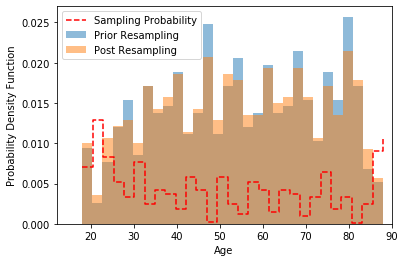

In [49]:
# Creating the parameters for the cross validation
scoring = {'MAE':'neg_mean_absolute_error', 'r2':'r2'}
X_total, y_total, cv = get_data_for_cross_val(X_trainval, y_trainval, features='full', augment=True, augment_percent=0.2)

### Performing the Cross-Val Grid Search on the different regressors

In [43]:
# With the random forest architecture
rf = RandomForestRegressor()
parameters_rf = {'n_estimators':[100, 500, 1000], 'bootstrap':('True', 'False'), 
                 'max_depth':[5, 10, 20],'random_state':[666], 'min_samples_split':[2, 5, 8]}
clf = GridSearchCV(estimator=rf, param_grid=parameters_rf, cv=cv, scoring=scoring, refit='MAE')
clf.fit(X_total, y_total.ravel())
print(clf.best_params_)
print(clf.best_score_)

In [ ]:
# With SVM
svm = SVR()
parameters_svm = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 50, 100]}
clf_svm = GridSearchCV(estimator=svm, param_grid=parameters_svm, cv=cv, scoring=scoring, refit='MAE')
clf_svm.fit(X_total, y_total.ravel())
print(clf_svm.best_params_)
print(clf_svm.best_score_)

In [ ]:
# With RIDGE linear regression
lin = linear_model.Ridge()
parameters_lin = {'alpha':[0, 0.5, 1, 1.5]}
clf_lin = GridSearchCV(estimator=lin, param_grid=parameters_lin, cv=cv, scoring=scoring, refit='MAE')
clf_lin.fit(X_total, y_total.ravel())
print(clf_lin.best_params_)
print(clf_lin.best_score_)

In [ ]:
# With Adaboost Regressor
ada = AdaBoostRegressor(random_state=None)
parameters_ada = {'n_estimators':[50, 100, 500], 
                  'learning_rate':[0.5, 1, 1.5],
                  'loss':('linear', 'square')
                 }
ada_grid = GridSearchCV(estimator=ada, param_grid=parameters_ada, cv=cv, scoring=scoring, refit='MAE')
ada_grid.fit(X_total, y_total.ravel())
print(ada_grid.best_params_)
print(ada_grid.best_score_)

### Comparing the best of each regressor

In [50]:
## With the best model for each of the regressors
## This is done to provide plots for the report, comparing the MAE and the r2 score

from sklearn import model_selection

models = []
models.append(('RF', RandomForestRegressor(bootstrap='True', max_depth=5, 
                                           n_estimators=500, min_samples_split=8)))
models.append(('SVM', SVR(kernel='rbf', C=10)))
models.append(('Ridge', linear_model.Ridge(alpha=0)))
models.append(('AdaBoost', AdaBoostRegressor(**{'learning_rate': 1, 'loss': 'linear', 'n_estimators': 100})))

results_mae = []
names_mae = []
scoring_mae = 'neg_mean_absolute_error'
results_r2 = []
names_r2 = []
scoring_r2 = 'r2'

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_total, y_total.ravel(), cv=cv, scoring=scoring['MAE'])
    results_mae.append(-cv_results)
    names_mae.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Perfromance Comparison')
ax = fig.add_subplot(111)
results_mae = np.array(results_mae)
data = pd.DataFrame(results_mae.T)
data.rename(columns={0:names_mae[0], 1: names_mae[1], 
                     2:names_mae[2], 3:names_mae[3]}, inplace = True)
sns.boxplot(data=data)
plt.ylabel('MAE')
plt.show()
plt.figure()

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_total, y_total.ravel(), cv=cv, scoring=scoring['r2'])
    results_r2.append(cv_results)
    names_r2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Perfromance Comparison')
ax = fig.add_subplot(111)
results_r2 = np.array(results_r2)
data_r2 = pd.DataFrame(results_r2.T)
data_r2.rename(columns={0:names_mae[0], 1: names_mae[1], 
               2:names_mae[2], 3:names_mae[3]}, inplace = True)
sns.boxplot(data=data_r2)
plt.ylabel('r2 score')
plt.show()

### Checking the final model performance

mean absolute error: 6.294241686963585
r2 score: 0.8421590522483676
mse: 59.688169971976


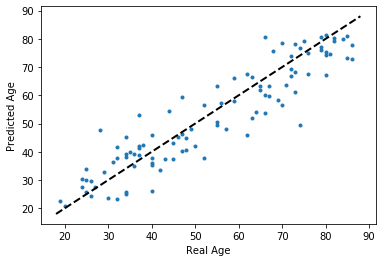

In [52]:
final_model = SVR(kernel='rbf', C=10)

# final data
augment=False
reduced=True

if reduced:
    X_train_val = _reduce_features(X_trainval)
    X_testing = _reduce_features(X_test)
    y_train_val = y_trainval
else:
    X_train_val = X_trainval
    X_testing = X_test
    y_train_val = y_trainval

if augment:
    X_train_val, y_train_val, up_points, probs = _augment_data(X_train_val, y_train_val, 0.2)
else:
    y_train_val = y_trainval

# Test
final_model.fit(X_train_val, y_train_val.ravel())
predictions = final_model.predict(X_testing)
print('mean absolute error: {0}'.format(mean_absolute_error(y_test,predictions)))
print('r2 score: {0}'.format(r2_score(y_test,predictions)))
print('mse: {}'.format(mean_squared_error(y_test, predictions, squared=True)))
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, marker='.')
ax.plot([y_train_val.min(), y_train_val.max()], [y_train_val.min(), y_train_val.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

Error calculation and plotting

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

In [53]:
########################################
# ADD YOUR CODE HERE
def downsample(img, factor=4):
    img_diff = sitk.GradientAnisotropicDiffusion(img)
    return img_diff[::factor, ::factor, ::factor]
########################################

In [29]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_data = list(meta_data_reg_train['subject_id'])
age_data = list(meta_data_reg_train['age'])
file_list_wm = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_data]

In [68]:
prepocessed_dir = './preprocessed'
if not os.path.exists(prepocessed_dir):
    os.makedirs(prepocessed_dir)
    
    img_data = np.empty((0, 109350)) #13068 90*108*90
    
    for name in file_list_wm:
        img = sitk.ReadImage(name)
        img_down = downsample(img)
        sitk.WriteImage(img_down, os.path.join(prepocessed_dir, name.split('/')[-1]))
        img_arr = sitk.GetArrayFromImage(img_down)
        img_flat = np.ndarray.flatten(img_arr).reshape((1,-1))
        img_data = np.append(img_data, img_flat, axis=0)
    np.save('preprocessed_flatten_grey_maps.npy', img_data)

In [55]:
# img_data = np.load('preprocessed_flatten_grey_maps.npy')
# img_data = np.load('preprocessed_flatten_grey_maps_down_four.npy')
# img_data = np.load('preprocessed_flatten_grey_maps_down_two_diff.npy')
img_data = np.load('preprocessed_flatten_grey_maps_down_four_diff.npy')

X = img_data
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 13068)
(500, 1)


In [ ]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_data_test = list(meta_data_reg_test['subject_id'])
age_data_test = list(meta_data_reg_test['age'])
file_list_wm_test = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_data_test]

In [ ]:
prepocessed_dir = './preprocessed/test'
if not os.path.exists(prepocessed_dir):
    os.makedirs(prepocessed_dir)
    
    img_data_test = np.empty((0, 109350)) #(45*54*45)  90*108*90
    
    for name in file_list_wm_test:
        img = sitk.ReadImage(name)
        img_down = downsample(img)
        sitk.WriteImage(img_down, os.path.join(prepocessed_dir, name.split('/')[-1]))
        img_arr = sitk.GetArrayFromImage(img_down)
        img_flat = np.ndarray.flatten(img_arr).reshape((1,-1))
        img_data_test = np.append(img_data_test, img_flat, axis=0)
    np.save('test_preprocessed_flatten_grey_maps.npy', img_data_test)

In [56]:
# img_data_test = np.load('test_preprocessed_flatten_grey_maps_down_four.npy')
# img_data_test = np.load('test_preprocessed_flatten_grey_maps.npy')
# img_data_test = np.load('test_preprocessed_flatten_grey_maps_down_two_diff.npy')
img_data_test = np.load('test_preprocessed_flatten_grey_maps_down_four_diff.npy')

X_test_pca = img_data_test
y_test_pca = meta_data_reg_test['age'].values.reshape(-1,1)

### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [57]:
########################################
# ADD YOUR CODE HERE
import sklearn.decomposition as decomp
# Create PCA instance
def get_pca(X_train, X_val):
    # set value found by testing with 0.95 to ensure that the two sets of cross validation 
    # are of the same shape
    pca = decomp.PCA(n_components=184) 
    # Fit the data
    pca.fit(X_train)
    # Transform the data
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
    print(X_train_pca.shape)
    return X_train_pca, X_val_pca
########################################

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

### Creating the function for resampling and constructing the cross validation iterables

In [61]:
# indices for the cross validation iterator
def _get_cv_pca(idx_xs1, idx_xs2, upsampled_points):
    '''This function serves to create the iterables for a 2 fold cross-validation.
    Input: 
        idx_xs1: np array of shape [number of samples in fold]
        idx_xs2: np array of shape [number of samples in fold]
        upsampled_points: int, number of additional points that have been obtained by upsampling
    Return:
        cv: tuple of tuples, iterable containing the indices of data to perform the 2 fold cross validation'''
    
    train1_max_idx = idx_xs1.shape[0] + upsampled_points
    test1_min_idx = train1_max_idx
    test1_max_idx = test1_min_idx + idx_xs2.shape[0]
    
    train2_min_idx = test1_max_idx
    train2_max_idx = train2_min_idx + idx_xs1.shape[0] + upsampled_points
    test2_min_idx = train2_max_idx
    test2_max_idx = test2_min_idx + idx_xs1.shape[0]

    cv = ((np.arange(0, train1_max_idx).tolist(), np.arange(test1_min_idx, test1_max_idx).tolist()),
          (np.arange(train2_min_idx, train2_max_idx).tolist(), np.arange(test2_min_idx, test2_max_idx).tolist()))
    
    return cv

In [63]:
#Augmentation for PCA
# Full pipeline

def get_data_for_cross_val_pca(X, y, augment=False, augment_percent=0.2):
    '''This fucntion serves to obtain the data to perform 2 fold cross validation ie: the features,
    labels, and cv validation iterable. It randomly selects half of each of the dataset and performs 
    augmentation (if required) on the training sets only.
    Input:
        X: np array containing the full train/validation set features of shape [samples, features]
        y: np array containing the full train/validation set labels of shape [samples, labels]
        features: string to specify if all the features are used, or only the reduced set
        augment: boolean informing if augemtation via upsampling is made
        augment_percent: float, percent by which the samples are increased
    Return:
        X_total: np array of the total samples (with augmentation or not) of shape [samples with augm, features]
        y_total: np array of the labels corrsponding with X_total [samples with augm, features]
        cv: tuple of tuple containing the indices for each fold of the cross validation.'''
    
    # Sparating the datapoints
    idx_xs1 = np.random.choice(X.shape[0], int(X.shape[0]/2), replace=False)
    idx_xs2 = np.setdiff1d(np.arange(X.shape[0]), idx_xs1)
    
    X_set1, y_set1 = X[idx_xs1,:], y[idx_xs1]
    X_set2, y_set2 = X[idx_xs2,:], y[idx_xs2]
    
    # augmenting the data
    if augment:
        X_set1, y_set1, upsampled_points, probs = _augment_data(X_set1, y_set1, augment_percent)
        X_set2, y_set2, upsampled_points, probs = _augment_data(X_set2, y_set2, augment_percent)
    else:
        upsampled_points = 0

    # Concatenating the features
    X_total = np.concatenate((X_set1, X_set2), axis=0)
    y_total = np.concatenate((y_set1, y_set2), axis=0)
    
    # Getting the PCA data -- ensuring that the training is fited and validation solely transformed
    X_set1_fit, X_set2_trans = get_pca(X_total[0:250+upsampled_points], 
                                       X_total[250+upsampled_points: 500+upsampled_points])
    X_set2_fit, X_set1_trans = get_pca(X_total[250+upsampled_points: 500+2*upsampled_points], 
                                       X_total[0:250])
    
    y_set1_fit = y_total[0:250+upsampled_points]
    y_set2_trans = y_total[250+upsampled_points: 500+upsampled_points]
    y_set2_fit = y_total[250+upsampled_points: 500+2*upsampled_points]
    y_set1_trans = y_total[0:250]
    
    X_total = np.concatenate((X_set1_fit, X_set2_trans, X_set2_fit, X_set1_trans), axis=0)
    y_total = np.concatenate((y_set1_fit, y_set2_trans, y_set2_fit, y_set1_trans), axis=0)
    
    if augment:
        cv = _get_cv_pca(idx_xs1, idx_xs2, upsampled_points)
    else:
        cv = _get_cv_pca(idx_xs1, idx_xs2, 0)

    return X_total, y_total, cv

X_pca, y_pca, cv = get_data_for_cross_val_pca(X, y, False)

(250, 184)
(250, 184)


### Performing the Cross-Val Grid Search on the different regressors

In [72]:
########################################
# ADD YOUR CODE HERE
# With the random forest architecture
rf = RandomForestRegressor(bootstrap='True')
parameters_rf = {'n_estimators':[100, 1000],
                 'max_depth':[2, 5, 10],
                 'min_samples_split':[2, 8]}#,'random_state':[666]}
rf_grid = GridSearchCV(estimator=rf, param_grid=parameters_rf, cv=cv, scoring=scoring, refit='MAE')
rf_grid.fit(X_pca, y_pca.ravel())
# print(clf.best_estimator_)
print(rf_grid.best_params_)
print(rf_grid.best_score_)
########################################

In [73]:
# With SVM
svm = SVR('linear')
# parameters_svm = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
parameters_svm = {'C':[1, 10, 20, 30, 50]}
svm_grid = GridSearchCV(estimator=svm, param_grid=parameters_svm, cv=cv, scoring=scoring, refit='MAE')
svm_grid.fit(X_pca, y_pca.ravel())
print(svm_grid.best_params_)
print(svm_grid.best_score_)

In [ ]:
# With Adaboost
ada = AdaBoostRegressor(random_state=None)
parameters_ada = {'n_estimators':[50, 100, 500], 
                  'learning_rate':[0.5, 1, 1.5],
                  'loss':('linear', 'square')
                 }
ada_grid = GridSearchCV(estimator=ada, param_grid=parameters_ada, cv=cv, scoring=scoring, refit='MAE')
ada_grid.fit(X_pca, y_pca.ravel())
print(ada_grid.best_params_)
print(ada_grid.best_score_)

In [ ]:
# With RIDGE linear regression
lin = linear_model.Ridge()
parameters_lin = {'alpha':[0, 0.5, 1, 1.5, 2, 2.5]}
lin_grid = GridSearchCV(estimator=lin, param_grid=parameters_lin, cv=cv, scoring=scoring, refit='MAE')
lin_grid.fit(X_pca, y_pca.ravel())
print(lin_grid.best_params_)
print(lin_grid.best_score_)

### Comparing the best of each regressor

In [66]:
## With the best model for each of the regressors
## This is done to provide plots for the report, comparing the MAE and the r2 score

from sklearn import model_selection

models = []
models.append(('RF', RandomForestRegressor(bootstrap='True', max_depth=10, 
                                           n_estimators=1000, min_samples_split=2)))
models.append(('SVM', SVR(kernel='linear', C=1)))
models.append(('Ridge', linear_model.Ridge(alpha=2.5)))
models.append(('AdaBoost', AdaBoostRegressor(**{'learning_rate': 1.5, 'loss': 'square', 'n_estimators': 500})))

results_mae = []
names_mae = []
scoring_mae = 'neg_mean_absolute_error'
results_r2 = []
names_r2 = []
scoring_r2 = 'r2'

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_pca, y_pca.ravel(), cv=cv, scoring=scoring['MAE'])
    results_mae.append(-cv_results)
    names_mae.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Perfromance Comparison')
ax = fig.add_subplot(111)
# plt.boxplot(results_mae)
results_mae = np.array(results_mae)
data = pd.DataFrame(results_mae.T)
data.rename(columns={0:names_mae[0], 1: names_mae[1], 
                     2:names_mae[2], 3:names_mae[3]}, inplace = True)
# ax.set_xticklabels(names_mae)
sns.boxplot(data=data)
plt.ylabel('MAE')
plt.show()
plt.figure()

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_pca, y_pca.ravel(), cv=cv, scoring=scoring['r2'])
    results_r2.append(cv_results)
    names_r2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Perfromance Comparison')
ax = fig.add_subplot(111)
# plt.boxplot(results_r2)
results_r2 = np.array(results_r2)
data_r2 = pd.DataFrame(results_r2.T)
data_r2.rename(columns={0:names_mae[0], 1: names_mae[1], 
               2:names_mae[2], 3:names_mae[3]}, inplace = True)
sns.boxplot(data=data_r2)
plt.ylabel('r2 score')
plt.show()

### Test performance with PCA features

Error calculation and plotting

(500, 13068) (100, 13068)
(500, 184)
(500, 184) (100, 184)
mean absolute error: 5.210612874763331
r2 score: 0.9035958505464725
mse: 36.455605092034304


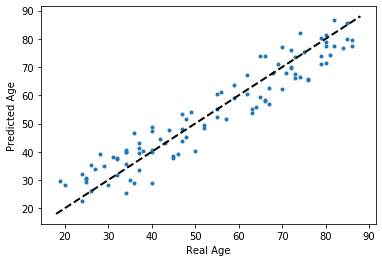

In [64]:
# final_model = RandomForestRegressor(bootstrap='True', max_depth=5, 
#                                     n_estimators=500, min_samples_split=8)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
final_model = SVR(kernel='linear', C=10)
final_model = linear_model.Ridge(alpha=0)

# final data
augment=False

X_train_val = X
X_testing = X_test_pca
y_train_val = y

if augment:
    X_train_val, y_train_val, up_points, _ = _augment_data(X_train_val, y_train_val, 0.1)
else:
    y_train_val = y_trainval

print(X_train_val.shape, X_testing.shape)
X_train_val, X_testing = get_pca(X_train_val, X_testing)    
print(X_train_val.shape, X_testing.shape)
# Test
final_model.fit(X_train_val, y_train_val.ravel())
predictions = final_model.predict(X_testing)
print('mean absolute error: {0}'.format(mean_absolute_error(y_test_pca, predictions)))
print('r2 score: {0}'.format(r2_score(y_test_pca, predictions)))
print('mse: {}'.format(mean_squared_error(y_test_pca, predictions, squared=True)))
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, marker='.')
ax.plot([y_train_val.min(), y_train_val.max()], [y_train_val.min(), y_train_val.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim

import pandas as pd
import numpy as np

data_dir = '../data/brain_age/'

## Getting the extra data/upsamlping
def augment_dataloader(dataset, augmentation):
    
    '''This fucntion serves to augment the data according to the inverse 
    probability distribution function in order to perfrom upsampling of the
    imbalanced age groups.
    Input: 
        features: list
        labels: list
        augmentation: float, %in data aumentation required
        upsampled_points: number of points added to the dataset'''
    
    features = [i['img'].to('cpu') for i in dataset]
    labels = [i['age'] for i in dataset]
    
    im_sz = list(features[0][0].shape)
    
    n, bins, patches = plt.hist(labels, 30, density=True, alpha=0.75)
    prob_dist = torch.from_numpy(np.ones(len(n)))-n*50
    prob_dist = prob_dist/sum(prob_dist)
    probs = torch.from_numpy(np.ones(len(labels)))
    
    # distriubute the probas according to the ages
    for idx in range(len(bins)-1):
        probs[(labels >= bins[idx])&(labels <=bins[idx+1])] = 1*prob_dist[idx]
    scaled_probs = probs/sum(probs)
    scaled_probs = torch.clamp(scaled_probs,0,1)
    scaled_probs = scaled_probs**2/sum(scaled_probs**2)

    upsampled_points = int(augmentation*len(features))
    idxs = torch.from_numpy(np.random.choice(len(labels), p=scaled_probs, size = upsampled_points))
    X_augmentation = torch.from_numpy(np.zeros(shape=([len(idxs)] + [1] + im_sz)))
    y_augmentation = torch.from_numpy(np.zeros(len(idxs)))
   
     # Adding noise propotrional to that of the resampling probability and standard deviation of the features
    for i, value in enumerate(idxs):
        std_feature = torch.std(features[value][0]).item()
        X_augmentation[i] = features[value] + torch.from_numpy(np.random.normal(0,
                                                           std_feature*5*scaled_probs[value],
                                                           size = features[value].shape))
        y_augmentation[i] = labels[value]
        
    X_augmentation = torch.clamp(X_augmentation,0,1)
    X_augmentation[X_augmentation < 0.05] = 0
    
    y_total=np.concatenate((labels, y_augmentation), axis=0)
    X_total=features + list(X_augmentation)
    tuple_set = (X_total, y_total)
    
    n, bins, patches = plt.hist(y_total, 30, density=True, alpha=0.75)
    prob_dist = np.ones(len(n))-n*50
    prob_dist = prob_dist/sum(prob_dist)
    probs = np.ones(len(labels))
    
    dset = []
    for i in range(len(features)+upsampled_points):
        dset.append({'img':X_total[i].float(), 'age':int(y_total[i])})
    
    return dset

# Class supports dataloader
class ImageRegDataset(Dataset):
    """Dataset for image regression."""

    def __init__(self, augmented_dset):
        self.samples = []

        for idx, _ in enumerate(tqdm(range(len(augmented_dset)), desc='Loading Data')):

            img = augmented_dset[idx]['img']

            age = augmented_dset[idx]['age']

            sample = {'img': img, 'age': age}

            self.samples.append(sample)
  
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = sample['img']
        age = sample['age']

        return {'img': image, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

print('Number of available GPUs are = {}'.format(torch.cuda.device_count()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))    

rnd_seed = 42 #fixed random seed

img_size = [76, 98, 88]
img_spacing = [2, 2, 2]

num_epochs = 30
num_save_epochs = 50

learning_rate = 2e-4
batch_size = 16
val_interval = 4 # Validation Interval

num_classes = 1

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

Number of available GPUs are = 1
Device: cuda:0
GPU: Tesla K80


In [15]:
class RegressionWMDataset(Dataset):
    """Dataset for image segmentation and regression."""

    def __init__(self, file_list_img, img_spacing, img_size, age_data):
        self.samples = []
        self.img_names = []
        
        for idx, _ in enumerate(tqdm(range(len(file_list_gm)), desc='Loading Data')):
            img_path = file_list_img[idx]
            
            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            #pre=processing
            img = resample_image(img, img_spacing, img_size, is_label=False)
            age = age_data[idx]
            
            sample = {'img': img, 'age':age}
            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        
        sample = self.samples[item]

        if isinstance(sample['img'], torch.Tensor):
            image = sample['img']
        else:
            image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).to(device).unsqueeze(0)
        age = sample['age']
        
        return {'img': image, 'age' : age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

    
bAugment = False
bCrVal = False
augment = 0.2

if bCrVal:
    # Train / val split
    meta_data_reg = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
    meta_data_reg_train = meta_data_reg.sample(n=int(len(meta_data_reg)/2))
    meta_data_reg_val = meta_data_reg.loc[~ meta_data_reg.index.isin(meta_data_reg_train.index)]

    # Train loader without upsampling
    ids_data = list(meta_data_reg_train['subject_id'])
    age_data = list(meta_data_reg_train['age'])
    file_list_gm = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_data]
    # dataset_train_reg = upsample(RegressionWMDataset(file_list_gm, img_spacing, img_size, age_data))
    dataset_train_reg = RegressionWMDataset(file_list_gm, img_spacing, img_size, age_data)
    dataloader_train_reg = torch.utils.data.DataLoader(dataset_train_reg, batch_size=batch_size, shuffle=True)

    # Val loader
    ids_data = list(meta_data_reg_val['subject_id'])
    age_data = list(meta_data_reg_val['age'])
    file_list_gm = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_data]
    dataset_val_reg = RegressionWMDataset(file_list_gm, img_spacing, img_size, age_data)
    dataloader_val_reg = torch.utils.data.DataLoader(dataset_val_reg, batch_size=batch_size, shuffle=True)

else:
    meta_data_train_reg = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
    ids_data = list(meta_data_train_reg['subject_id'])
    age_data = list(meta_data_train_reg['age'])
    file_list_gm = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_data]
    dataset_full_train_reg = RegressionWMDataset(file_list_gm, img_spacing, img_size, age_data)
    if bAugment:
        aug_dataset_full_train_reg = augment_dataloader(dataset_full_train_reg, augment)
        dsetimg = ImageRegDataset(aug_dataset_full_train_reg)
        dataloader_train_reg = torch.utils.data.DataLoader(dsetimg, batch_size=batch_size, shuffle=True)
    else: 
        dataloader_train_reg = torch.utils.data.DataLoader(dataset_full_train_reg, batch_size=batch_size, shuffle=True)

# Test loader
meta_data_test_reg = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_data = list(meta_data_test_reg['subject_id'])
age_data = list(meta_data_test_reg['age'])
file_list_gm = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_data]
dataset_full_test_reg = RegressionWMDataset(file_list_gm, img_spacing, img_size, age_data)
dataloader_test_reg = torch.utils.data.DataLoader(dataset_full_test_reg, batch_size=batch_size, shuffle=True)

print("TRAIN\t" + str(dataset_full_train_reg.__len__()))
print("TEST\t" + str(dataset_full_test_reg.__len__()))

TRAIN	500
TEST	100


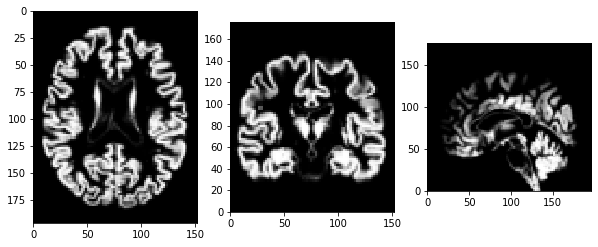

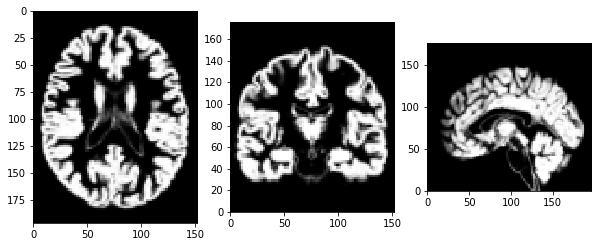

In [16]:
display_image(dataset_full_train_reg.get_sample(0)['img'])
display_image(dataset_full_test_reg.get_sample(1)['img'])

In [17]:
#########################
# REGRESSION MODEL HERE #
#########################

class ModelBlock(nn.Module): 
    def __init__(self, block):
        super(ModelBlock, self).__init__() 
        self.block = nn.Sequential(*block)
    
    def forward(self, x): 
        out = self.block(x) 
        return out

class ResBlock(nn.Module): 
    def __init__(self, in_channel, out_channel, kernel_size = 3, stride=1): 
        
        super(ResBlock, self).__init__() 
        
        self.left = nn.Sequential(nn.Conv3d(in_channel, out_channel, 
                                            kernel_size=kernel_size, stride=stride, 
                                            padding=1, bias=False), 
                                  nn.BatchNorm3d(out_channel), 
                                  nn.ReLU(inplace=True), 
                                  
                                  nn.Conv3d(out_channel, out_channel, 
                                            kernel_size=kernel_size, stride=1, 
                                            padding=1, bias=False), 
                                  nn.BatchNorm3d(out_channel))
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or in_channel != out_channel: 
            
            self.shortcut = nn.Sequential(nn.Conv3d(in_channel, out_channel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm3d(out_channel))
                                          
    def forward(self, x): 
        out = self.left(x)
        out += self.shortcut(x) 
        out = F.relu(out) 
        return out


class ResidualNet3D_Regression(nn.Module):

    def __init__(self, ResBlock, ModelBlock, dp = 0.2):
        super(ResidualNet3D_Regression, self).__init__()
        
        self.dp = dp
        f = 2
        self.in_channel = int(8*f)
        self.fc_in_features = 64
        
        self.conv1 = nn.Sequential(nn.Conv3d(1, self.in_channel, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm3d(self.in_channel),
                                  nn.ReLU(inplace = True),
                                  )
        
        self.layer1 = self.make_layer(ResBlock, num_blocks = 2, out_channel = int(16*f), stride = 2)
        self.layer2 = self.make_layer(ResBlock, num_blocks = 1, out_channel = int(32*f), stride = 2)
        self.layer3 = self.make_layer(ResBlock, num_blocks = 1, out_channel = int(48*f), stride = 2)
        self.layer4 = self.make_layer(ResBlock, num_blocks = 1, out_channel = int(32*f), stride = 2)
        self.layer5 = self.make_layer(ResBlock, num_blocks = 2, out_channel = int(16*f), stride = 2)
        
        # USED FOR REGRESSION TASK
        self.maxpool = nn.MaxPool3d(2)
        self.fc = self.make_fc([28],1)
                                  
    def make_layer(self, block, num_blocks, out_channel, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(ResBlock(self.in_channel, out_channel, stride = stride))
            self.in_channel = out_channel 
            
        return nn.Sequential(*layers)
    
    # USED FOR CLASSIFICATION TASK
    def make_fc(self, hidden_layers, num_classes):
        
        layers = []
        fc_layers = hidden_layers + [num_classes]
        in_features = self.fc_in_features
        
        for hl in fc_layers:
            if hl is fc_layers[-1]:
                # We do not want ReLU in the output
                block = [nn.Linear(in_features,hl, 
                                   bias = True)]
            else:
                print(in_features, hl)
                block = [nn.Linear(in_features,hl, 
                                   bias = True), 
                         nn.ReLU(inplace = True),
                         nn.Dropout(self.dp)]
                
            module_block = ModelBlock(block)
            layers.append(module_block)
            in_features = hl
            
        return nn.Sequential(*layers)
                                  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        
        # THIS IS FOR REGRESSION
        x = self.maxpool(x)
        x = x.view(-1,self.fc_in_features)
        x = self.fc(x)
        return x   

torch.manual_seed(rnd_seed) #fix random seed

model_dir_reg = os.path.join(out_dir, 'model_reg')
if not os.path.exists(model_dir_reg):
    os.makedirs(model_dir_reg)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [18]:
def cross_val_reg(dataset_train_reg, dataset_val_reg, augment = 0.2, bSave = True):
    
    """Cross validation function. 
    INPUTS: - dataset_train_reg first fold of cross_validation_dataset, type: list(dictionary{'img','age'})
            - dataset_val_reg second fold of cross_validation_dataset, " "
            - augment : augmentation scale for resampling
            - bSave: boolean to save models
    OUTPUTS: - loss_train_log, loss_val_log, MAE_val_log, MAE_train_log, epoch_val_log
    """
    
    loss_train_log = {'train':[],'val':[]}
    loss_val_log = {'train':[],'val':[]}
    MAE_train_log = {'train':[],'val':[]}
    MAE_val_log = {'train':[],'val':[]}
    epoch_val_log = {'train':[],'val':[]}

    for cv_fold in range(1,3):
        
        model_reg = ResidualNet3D_Regression(ResBlock, ModelBlock, dp = 0.4).to(device)
        model_reg.apply(weights_init)
        params_net = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)
        print("Total number of parameters in Model is: {}".format(params_net))
        print(model_reg)

        optimizer = torch.optim.Adam(model_reg.parameters(), lr=learning_rate, betas=(0.9, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.95)
        
        if cv_fold is 1:
            save_string = 'train'
            
            if augment is not 0:
                tmp_dataset_train_reg = augment_dataloader(dataset_train_reg, augment)
                tmp_dataset_train_reg = ImageRegDataset(tmp_dataset_train_reg)
            dataloader_train_reg = torch.utils.data.DataLoader(tmp_dataset_train_reg, batch_size=batch_size, shuffle=True)
            dataloader_val_reg = torch.utils.data.DataLoader(dataset_val_reg, batch_size=batch_size, shuffle=True)
            
            dataloader_train = dataloader_train_reg
            dataloader_val = dataloader_val_reg
            color = 'r'
            
        elif cv_fold is 2:
            save_string = 'val'
            
            if augment is not 0:
                tmp_dataset_val_reg = augment_dataloader(dataset_val_reg, augment)
                tmp_dataset_val_reg = ImageRegDataset(dataset_val_reg)
            dataloader_train_reg = torch.utils.data.DataLoader(tmp_dataset_val_reg, batch_size=batch_size, shuffle=True)
            dataloader_val_reg = torch.utils.data.DataLoader(dataset_train_reg, batch_size=batch_size, shuffle=True)
            
            dataloader_train = dataloader_train_reg
            dataloader_val = dataloader_val_reg
            color = 'b'
            
        else:
            print('WRONG FOLDS')
            break
        
        print('START TRAINING ON FOLD {}...'.format(save_string))
        for epoch in range(1, num_epochs + 1):
            model_reg.train()
            tmploss = 0
            AE = 0
            # Training
            for batch_idx, batch_samples in enumerate(dataloader_train):
                img, age = batch_samples['img'].to(device), batch_samples['age'].to(device)
                optimizer.zero_grad()
                prd = model_reg(img)
                age = age.view(-1,1).float()
                loss = F.mse_loss(prd, age)
                
                tmploss += loss.detach().item()
                AE += torch.sum(torch.abs(age - prd)).item()
                
                loss.backward()
                optimizer.step()

            MAE = AE/len(dataloader_train.dataset.samples)
            loss_train_log[save_string].append(tmploss/len(dataloader_train.dataset.dataset.samples))
            MAE_train_log[save_string].append(MAE)

            print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, tmploss/len(dataloader_train.dataset.samples)))

            # Validation
            if epoch == 1 or epoch % val_interval == 0:
                model_reg.eval()
                loss_val = 0
                AE = 0
                with torch.no_grad():
                    for batch_idx, batch_samples in enumerate(dataloader_val):
                        img, age = batch_samples['img'].to(device), batch_samples['age'].to(device)
                        prd = model_reg(img)
                        age = age.view(-1,1).float()
                        loss_val += F.mse_loss(prd, age)
                        AE += torch.sum(torch.abs(age - prd)).item()

                MAE = AE/len(dataloader_val.dataset.samples)
                loss_val = loss_val/len(dataloader_val.dataset.samples)

                loss_val_log[save_string].append(loss_val)
                epoch_val_log[save_string].append(epoch)
                MAE_val_log[save_string].append(MAE)

                print('--------------------------------------------------')
                print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
                print('MAE\t {}'.format(MAE))
                print('--------------------------------------------------')

            if epoch % num_save_epochs == 0 and bSave:
                print('SAVING MODEL JUST IN CASE')
                torch.save(model_reg.state_dict(), os.path.join(model_dir_reg, 'cv_model_reg_.pt'.format(save_string)))


        print('\nFinished TRAINING of fold {}'.format(cv_fold))
        if bSave:
            torch.save(model_reg.state_dict(), os.path.join(model_dir_reg, 'cv_model_reg_{}.pt'.format(save_string)))
            print('FULL MODEL SAVED SUCCESSFULLY')

        plt.plot(range(1, num_epochs + 1), loss_train_log[save_string], c=color, linestyle = '-',
                 label='train_{}'.format(cv_fold))
        plt.plot(epoch_val_log[save_string], loss_val_log[save_string], c=color, linestyle = '--',
                 label='val_{}'.format(cv_fold))
        plt.legend(loc='upper right')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    
    return loss_train_log, loss_val_log, MAE_val_log, MAE_train_log, epoch_val_log

64 24
Total number of parameters in Model is: 1113025
ResidualNet3D_Regression(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_ru


Loading Data: 100%|██████████| 350/350 [00:00<00:00, 734370.39it/s]


START TRAINING ON FOLD train...
+ TRAINING 	Epoch: 1 	Loss: 112.146968
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 62.835182
MAE	 27.147640502929686
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 35.215911
+ TRAINING 	Epoch: 3 	Loss: 22.355131
+ TRAINING 	Epoch: 4 	Loss: 21.748018
--------------------------------------------------
+ VALIDATE 	Epoch: 4 	Loss: 5.089822
MAE	 7.146953857421875
--------------------------------------------------
+ TRAINING 	Epoch: 5 	Loss: 19.916230
+ TRAINING 	Epoch: 6 	Loss: 18.222326
+ TRAINING 	Epoch: 7 	Loss: 18.716007
+ TRAINING 	Epoch: 8 	Loss: 17.567859
--------------------------------------------------
+ VALIDATE 	Epoch: 8 	Loss: 16.750238
MAE	 13.850951171875
--------------------------------------------------
+ TRAINING 	Epoch: 9 	Loss: 14.766081
+ TRAINING 	Epoch: 10 	Loss: 17.850971
+ TRAINING 	Epoch: 11 	Loss: 15.916610
+ TRAINING 	Epoch: 12 	Loss: 17.078482
---------------------

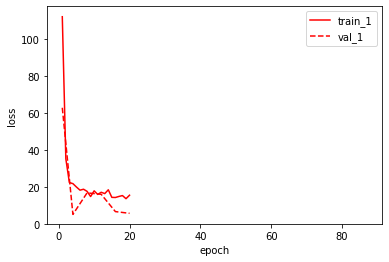

64 24
Total number of parameters in Model is: 1113025
ResidualNet3D_Regression(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_ru


Loading Data: 100%|██████████| 250/250 [00:00<00:00, 564.16it/s]


START TRAINING ON FOLD val...
+ TRAINING 	Epoch: 1 	Loss: 97.875158
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 59.134525
MAE	 25.2519716796875
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 34.102509
+ TRAINING 	Epoch: 3 	Loss: 16.848292
+ TRAINING 	Epoch: 4 	Loss: 22.214800
--------------------------------------------------
+ VALIDATE 	Epoch: 4 	Loss: 6.080730
MAE	 7.908421234130859
--------------------------------------------------
+ TRAINING 	Epoch: 5 	Loss: 20.513397
+ TRAINING 	Epoch: 6 	Loss: 21.839649
+ TRAINING 	Epoch: 7 	Loss: 18.381756
+ TRAINING 	Epoch: 8 	Loss: 20.039301
--------------------------------------------------
+ VALIDATE 	Epoch: 8 	Loss: 20.802258
MAE	 15.865799011230468
--------------------------------------------------
+ TRAINING 	Epoch: 9 	Loss: 18.598876
+ TRAINING 	Epoch: 10 	Loss: 19.423150
+ TRAINING 	Epoch: 11 	Loss: 23.256332
+ TRAINING 	Epoch: 12 	Loss: 20.497593
-----------------------

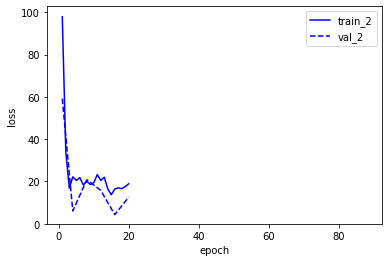

In [27]:
# RUNNINC CROSS VALIDATION
loss_train_log, loss_val_log, MAE_val_log, MAE_train_log, epoch_val_log = cross_val_reg(dataset_train_reg, dataset_val_reg, augment = 0.2, bSave = True)

64 28
Total number of parameters in Model is: 1113289
ResidualNet3D_Regression(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

--------------------------------------------------
+ VALIDATE 	Epoch: 28 	Loss: 4.136278
MAE	 6.376798706054688
--------------------------------------------------
+ TRAINING 	Epoch: 29 	Loss: 8.353378
MAE	 8.698294666290284
+ TRAINING 	Epoch: 30 	Loss: 7.131536
MAE	 8.168976112365723

Finished TRAINING.


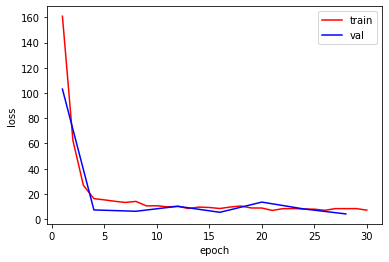

In [24]:
# RUNNING WITH THE ENTIRE DATASET
model_reg = ResidualNet3D_Regression(ResBlock, ModelBlock, dp = 0.2).to(device)

weights_initialiser = True

if weights_initialiser:
    model_reg.apply(weights_init)
params_net = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)
print("Total number of parameters in Model is: {}".format(params_net))
print(model_reg)

optimizer = torch.optim.Adam(model_reg.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.9)

loss_train_log = []
loss_val_log = []
MAE_val_log = []
MAE_train_log = []
epoch_val_log = []

torch.autograd.set_detect_anomaly(True)

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):
    model_reg.train()
    tmploss = 0
    AE = 0
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train_reg):
        img, age = batch_samples['img'].to(device), batch_samples['age'].to(device)
        optimizer.zero_grad()
        prd = model_reg(img)
        age = age.view(-1,1).float()
        loss = F.mse_loss(prd, age)
        
        tmploss += loss.detach().item()
        AE += torch.sum(torch.abs(age - prd)).item()
        
        loss.backward()
        optimizer.step()

    tmploss = tmploss/len(dataloader_train_reg.dataset.samples)
    MAE = AE/len(dataloader_train_reg.dataset.samples)
    
    loss_train_log.append(tmploss)
    MAE_train_log.append(MAE)
    
    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, tmploss))
    print('MAE\t {}'.format(MAE))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        model_reg.eval()
        loss_val = 0
        AE = 0
        with torch.no_grad():
            for batch_idx, batch_samples in enumerate(dataloader_test_reg):
                img, age = batch_samples['img'].to(device), batch_samples['age'].to(device)
                prd = model_reg(img)
                age = age.view(-1,1).float()
                loss_val += F.mse_loss(prd, age)
                AE += torch.sum(torch.abs(age - prd)).item()
                
        MAE = AE/len(dataloader_test_reg.dataset.samples)
        loss_val = loss_val/len(dataloader_test_reg.dataset.samples)
        
        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        MAE_val_log.append(MAE)
        
        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        print('MAE\t {}'.format(MAE))
        print('--------------------------------------------------')
    
    if epoch % num_save_epochs == 0:
        pass
        print('SAVING MODEL JUST IN CASE')
        torch.save(model_reg.state_dict(), os.path.join(model_dir_reg, 'model_reg.pt'))
    
    
print('\nFinished TRAINING.')
torch.save(model_reg.state_dict(), os.path.join(model_dir_reg, 'model_reg.pt'))
print('FULL MODEL SAVED SUCCESSFULLY')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

64 28
mean absolute error: 6.110010452270508
r2 score: 0.8532166730166211


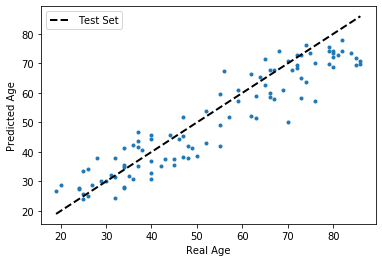

mean absolute error: 3.340884937286377
r2 score: 0.9479205385404983


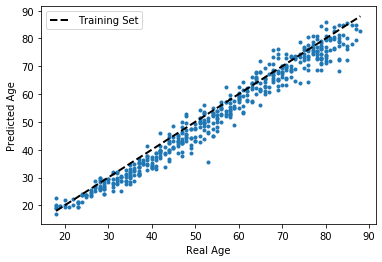

In [37]:
model_reg = ResidualNet3D_Regression(ResBlock, ModelBlock)
model_reg.load_state_dict(torch.load(os.path.join(model_dir_reg, 'model_reg.pt')))
model_reg.to(device)
model_reg.eval()

def find_y_pred(model_reg, dataloader_test_reg):
    y = []
    predicted = []
    model_reg.eval()
    for batch in dataloader_test_reg:
        y_batch = batch['age'].to(device)
        y_pred = model_reg(batch['img'].to(device))
        batch_lst = [yval.item() for yval in list(y_batch.detach())]
        pred_lst = [ypred.item() for ypred in list(y_pred.detach())]
        for idx in range(len(batch_lst)):
            y.append(batch_lst[idx])
            predicted.append(pred_lst[idx])
    y = np.array(y)
    predicted = np.array(predicted)
    y = y.flatten()
    predicted = predicted.flatten()
    return y, predicted


# TEST SET
y, predicted = find_y_pred(model_reg, dataloader_test_reg)

print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label = 'Test Set')
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.legend()
plt.show()

# TRAINING SET
y, predicted = find_y_pred(model_reg, dataloader_train_reg)

print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label = 'Training Set')
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.legend()
plt.show()

# VALIDATION SET (REDUNDANT FOR FINAL TEST)
# y, predicted = find_y_pred(model_reg, dataloader_val_reg)

# print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
# print('r2 score: {0}'.format(r2_score(y,predicted)))

# fig, ax = plt.subplots()
# ax.scatter(y, predicted, marker='.')
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# ax.set_xlabel('Real Age')
# ax.set_ylabel('Predicted Age')
# plt.show()

In [36]:
torch.cuda.empty_cache()